In [34]:
using  Plots, Optim, Dates, DiffEqParamEstim, Flux, DiffEqFlux, OrdinaryDiffEq

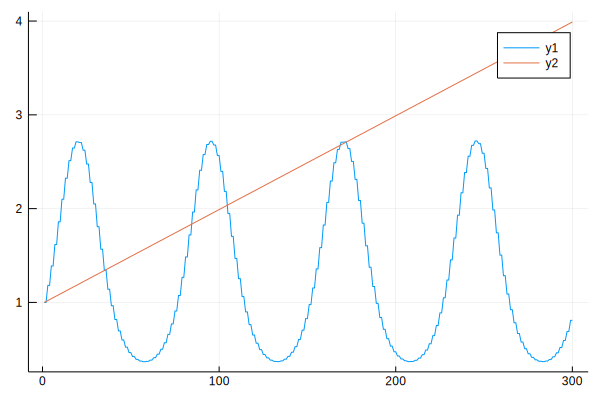

In [36]:
# Start conditions for the two species in the system
u0 = Float32[1.; 1.]
# Number of evaluations of the neural ODE. It relates to the numbers of layers of the neural net (depth of network).
datasize = 300
# Time span in which of evaluation will be and actual timepoints of evaluations
tspan = (0.0f0, 50.f0)
t = range(tspan[1], tspan[2], length = datasize)
# The true ODE (with the true parameters) which the neural net should learn
function trueODEfunc(du, u, p, t)
    du[1]=u[1]*cos(t)
    du[2]=u[2]*cos(t)
end
y = ones(datasize);
for i in 2:length(y)
    y[i]=y[i-1]+0.01
end

# Construction of the ODEProblem and solving the ODEProblem with Tsit5 solver
prob = ODEProblem(trueODEfunc, u0, tspan)
ode_data = Array(solve(prob,Tsit5(),saveat=t))
ode_data = transpose(hcat(ode_data[1:datasize],y[1:datasize]))

species1 = "1"
species2 = "2"
plot(ode_data')

In [37]:
mutable struct saver
    losses::Array{Float64,1}
    l2s::Array{Float64,1}
    times::Array{Dates.Time,1}
    count_epochs::Int128
end
function saver(n_epochs)
    losses = zeros(n_epochs)
    l2s = zeros(n_epochs)
    times = fill(Dates.Time(Dates.now()),n_epochs)
    count_epochs = 0
    return saver(losses,l2s,times,count_epochs)
end
function update_saver(saver, loss_i, l2_i, time_i)
    epoch_i = saver.count_epochs
    saver.losses[epoch_i] = loss_i
    saver.l2s[epoch_i] = l2_i
    saver.times[epoch_i] = time_i
end

update_saver (generic function with 1 method)

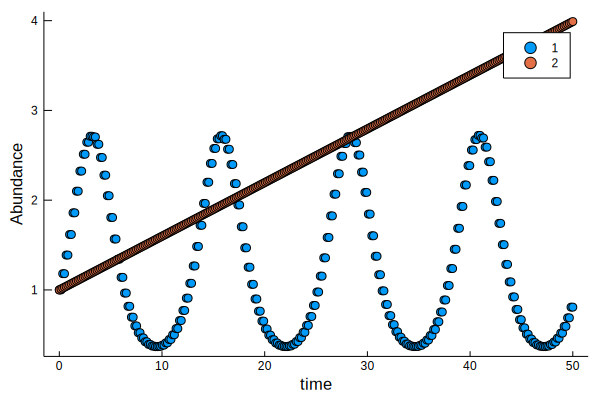

In [38]:
scatter(t, ode_data[1,:], grid = "off", xlab = "time", ylab = "Abundance", label = species1)
scatter!(t, ode_data[2,:], label = species2)

In [39]:
# Building a neural ODE 
# Derivative is modeled by a neural net. Chain concatinates the functions ode function and two dense layers.
dudt = Chain(Dense(2,500,tanh),
       Dense(500,500,tanh),
        Dense(500,500,tanh),
        Dense(500,500,tanh),
       Dense(500,2))
# Parameters of the model which are to be learnt. They are: W1 (2x50), b1 (50), W2 (50x2), b2 (2)
ps = Flux.params(dudt)
# Getting loss function from two stage collocation function
function node_two_stage_function(model, x, tspan, saveat, ode_data,
            args...; kwargs...)
  dudt_(du,u,p,t) = du .= model(u)
  prob_fly = ODEProblem(dudt_,x,tspan)
  two_stage_method(prob_fly, saveat, ode_data)
end
loss_n_ode = node_two_stage_function(dudt, u0, tspan, t, ode_data, Tsit5(), reltol=1e-7, abstol=1e-9)
#  loss function
two_stage_loss_fct()=loss_n_ode.cost_function(ps)
# Defining anonymous function for the neural ODE with the model. in: u0, out: solution with current params.
n_ode = x->neural_ode(dudt, x, tspan, Tsit5(), saveat=t, reltol=1e-7, abstol=1e-9)
n_epochs = 1000
verify = 25 # for <verify>th epoch the L2 is calculated  
data1 = Iterators.repeated((), n_epochs)
opt1 = ADAM(0.0001)
sa = saver(n_epochs)
L2_loss_fct() = sum(abs2,ode_data .- n_ode(u0))
# Callback function to observe two stage training.
cb1 = function ()
    sa.count_epochs = sa.count_epochs +  1
    if mod(sa.count_epochs-1, verify)==0
        update_saver(sa, Tracker.data(two_stage_loss_fct()),Tracker.data(L2_loss_fct()), Dates.Time(Dates.now()))
        # println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    else
        update_saver(sa, Tracker.data(two_stage_loss_fct()),0,Dates.Time(Dates.now()))
        # println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    end
end


#19 (generic function with 1 method)

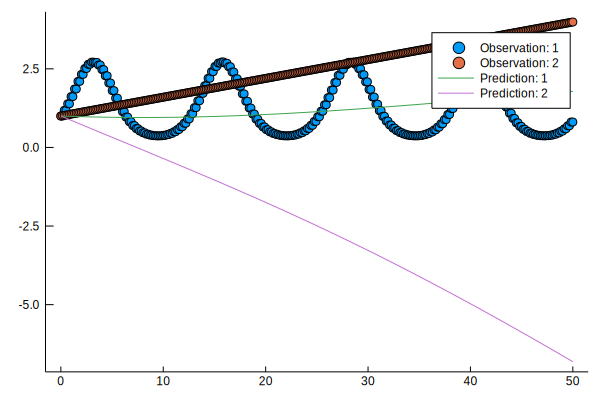

In [41]:
pred = n_ode(u0)
scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation: ", species2))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species2))

In [42]:
# train n_ode with collocation method
@time Flux.train!(two_stage_loss_fct, ps, data1, opt1, cb = cb1)


InterruptException: InterruptException:

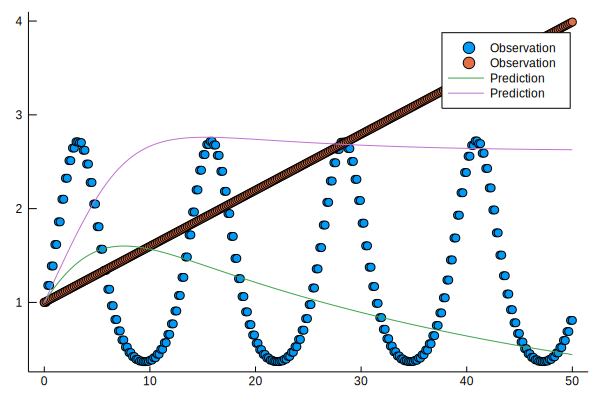

In [43]:
pred = n_ode(u0)
scatter(t, ode_data[1,:], label = string("Observation "), grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation "))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction "))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction "))


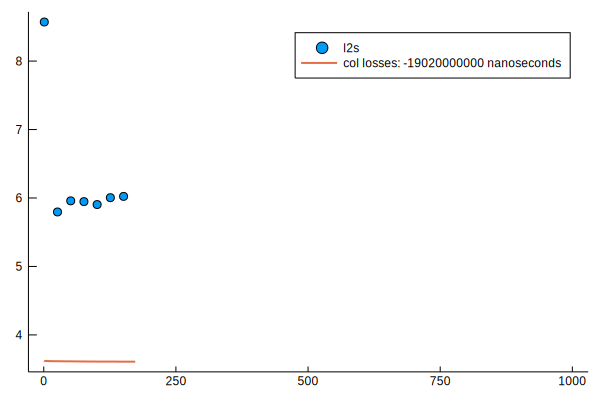

In [44]:
header = string("col losses: ", sa.times[end] - sa.times[1])
scatter(range(1,stop=length(sa.l2s)),log.(sa.l2s),width  =2, label = "l2s", grid = "off")
plot!(range(1,stop=length(sa.losses)),log.(sa.losses), width  =2, label = header)
# 5% of time even with l2s